# ML-7. Практика. Оптимизация гиперпараметров

## Прогнозирование биологического ответа

##### Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

##### В качестве метрики будем использовать F1-score.

In [221]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV #поиск параметров по сетке
from sklearn.model_selection import RandomizedSearchCV #случайный поиск параметров
from sklearn.model_selection import cross_val_score #оценка по кросс-валидации
import hyperopt #оптимизация гиперпараметров
from hyperopt import hp, fmin, tpe, Trials #оптимизация гиперпараметров с использованием Hyperopt
import optuna #оптимизация гиперпараметров с использованием Optuna

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [114]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 

* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

> Предварительная обработка не требуется, данные уже закодированы и нормализованы.

Смотрим на сбалансированность классов:

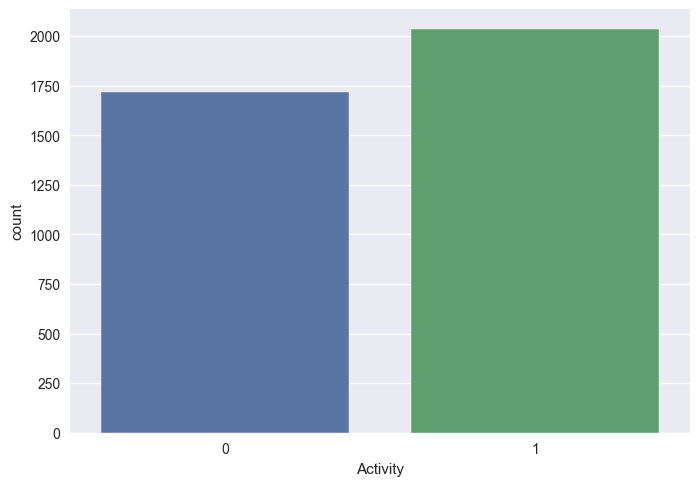

In [115]:
sns.countplot(data=data, x='Activity');

Распределение классов в датасете является относительно сбалансированным. В первую очередь мы выделим из датасета целевой признак, который называется "Activity". 

Создаем матрицу наблюдений $X$ и вектор ответов $y$:

In [116]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

In [118]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('Train: f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = log_reg.predict(X_test)
print('Test: f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: f1_score: 0.89
Test: f1_score: 0.78


### Cлучайный лес

In [119]:
#Создаём объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
print('Train: f1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test)
print('Test: f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: f1_score: 1.00
Test: f1_score: 0.81


## <center> **GridSearchCV**

### GridSearchCV для логистической регрессии

In [ ]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

#CPU times: user 1.23 s, sys: 64.7 ms, total: 1.29 s
#Wall time: 4.43 s
#f1_score на обучающем наборе: 0.86
#f1_score на тестовом наборе: 0.78
#Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}

> Значение F1-меры на модели, обученной с использованием GridSearchCV, не изменилось и осталось таким же, как и у базовой логистической регрессии.

**Попробуем расширить сетку гиперпараметров.**

In [ ]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search_1.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

#CPU times: user 2.04 s, sys: 305 ms, total: 2.34 s
#Wall time: 45.7 s
#f1_score на обучающем наборе: 0.86
#f1_score на тестовом наборе: 0.79
#Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

> При использовании GridSearchCV с подбором других параметров, F1-мера незначительно увеличилась с 0.78 до 0.79.

### GridSearchCV для случайного леса

In [78]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search_forest.fit(X_train, y_train) 

y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 1.22 s, sys: 98.8 ms, total: 1.32 s
Wall time: 19.3 s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


In [222]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшая модель:
LogisticRegression(max_iter=50, random_state=42, solver='saga')
Наилучшее значение точности при кросс-валидаци: 0.76


> > В обоих случаях модель случайного леса показывает хорошие результаты на обучающем наборе данных, где метрика F1-score равна или близка к 1.00. Это свидетельствует о хорошей способности модели к классификации обучающих данных. Однако, на тестовом наборе данных производительность модели немного снижается, где метрика F1-score составляет 0.81 в первом случае и 0.82 во втором случае. Это может указывать на некоторое переобучение модели, когда она не обобщается так хорошо на новые данные.

---

## <center> **RandomizedSearchCV**

### RandomizedSearchCV для логистической регресии

In [ ]:
param_distributions = {'penalty': ['l2', 'none'],
                       'solver': ['lbfgs', 'sag'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float))}

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter=10, 
    n_jobs=-1
)  
%time random_search.fit(X_train, y_train) 

y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

#CPU times: user 2.09 s, sys: 115 ms, total: 2.21 s
#Wall time: 1min 25s
#f1_score на обучающем наборе: 0.82
#f1_score на тестовом наборе: 0.80
#Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

> В случае базовой логистической регрессии модель показывает F1-score 0.89. Однако, на тестовом наборе данных производительность модели немного снижается до 0.78, что может свидетельствовать о некотором переобучении.
В случае RandomizedSearchCV для логистической регрессии производительность модели немного снижается на обучающем наборе (0.82). Возможно, в ходе поиска гиперпараметров RandomizedSearchCV не удалось найти оптимальные значения, которые были бы лучше базовой модели.

### RandomizedSearchCV для случайного леса

In [97]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [ 10, 15, 20, 25]
              }
            
random_search_rf = RandomizedSearchCV(ensemble.RandomForestClassifier(
    random_state=42), 
    param_distributions,
    cv=5,
    n_iter = 10, 
    n_jobs = -1)  

%time random_search_rf.fit(X_train, y_train) 

y_train_pred = random_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

CPU times: user 1.01 s, sys: 63.3 ms, total: 1.07 s
Wall time: 11.1 s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 7, 'max_depth': 20}


> RandomizedSearchCV помог найти набор гиперпараметров для случайного леса, который снизил переобучение модели и улучшил ее обобщающую способность.

---

## <center> Hyperopt

### Hyperopt для логистической регресии

In [ ]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'sag', 'saga']),
    'C': hp.loguniform('C', np.log(0.01), np.log(100))
}

random_state = 42

def hyperopt_logreg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    penalty = params['penalty']
    solver = params['solver']
    C = float(params['C'])

    model = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        random_state=random_state,
        max_iter=50
    )

    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(
    hyperopt_logreg,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(random_state)
)

penalty = 'l2'
solver = ['newton-cg', 'lbfgs', 'sag', 'saga'][best['solver']]
C = float(best['C'])

model = linear_model.LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=C,
    random_state=random_state
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

#f1_score на обучающем наборе: 0.83
#f1_score на тестовом наборе: 0.80

> Использование Hyperopt для оптимизации гиперпараметров логистической регрессии не привело к значительному улучшению производительности модели на данном наборе данных. 

### Hyperopt для случайного леса

In [173]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 301, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),   
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']))
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [01:02<00:00,  3.13s/trial, best loss: -0.8097798646226206]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.83


>  Значение F1-score на тестовом наборе данных повысилось с 0.81 до 0.83, что указывает на улучшение производительности модели на новых данных.

---

## <center> Optuna

### Optuna для логистической регресии

In [ ]:
def optuna_lr(trial):
    # Задаем пространство поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)

    # Создаем модель
    model = linear_model.LogisticRegression(penalty=penalty, solver=solver, C=C, random_state=random_state, max_iter=50)
    
    # Обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=30)

In [220]:
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(study.best_params))


f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.76
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'newton-cg', 'C': 9.909518798832382}


> При использовании Optuna для оптимизации гиперпараметров логистической регрессии, значение F1-score на обучающем наборе данных повысилось с 0.89 до 0.93. Это указывает на улучшение способности модели к предсказанию положительного класса на обучающих данных. Однако, значение F1-score на тестовом наборе данных снизилось с 0.78 до 0.76. Это может указывать на переобучение модели.

### Optuna для случайного леса

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

%time random_search_rf.fit(X_train, y_train) 
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)


#CPU times: user 982 ms, sys: 67.3 ms, total: 1.05 s
#Wall time: 11.1 s

In [201]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

f1_score на тестовом наборе: 0.99
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров {'n_estimators': 193, 'max_depth': 29, 'min_samples_leaf': 2}


In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

In [212]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

f1_score на тестовом наборе: 0.98
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 3}


Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [213]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

Из графика можно сделать вывод, что метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [214]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf.

> Значение F1-score на тестовом наборе данных повысилось с 0.81 до 0.83. Это указывает на улучшение обобщающей способности модели на новых данных.

---

Логистическая регрессия F1-score:
- Train: 0.89
- Test: 0.78

Случайный лес F1-score:
- Train: 1.00
- Test: 0.81

GridSearchCV для логистической регрессии:
- Train: 0.86
- Test: 0.78

GridSearchCV для случайного леса:
- Train: 0.94
- Test: 0.82

RandomizedSearchCV для логистической регрессии:
- Train: 0.82
- Test: 0.80

RandomizedSearchCV для случайного леса:
- Train: 0.93
- Test: 0.82

HyperOpt для логистической регрессии:
- Train: 0.83
- Test: 0.80

HyperOpt для случайного леса:
- Train: 0.98
- Test: 0.83

Optuna для логистической регрессии:
- Train: 0.93
- Test: 0.76

Opyuna для случайного леса:
- Train: 0.98
- Test: 0.83

> На основании проведенных экспериментов с различными методами настройки гиперпараметров для моделей логистической регрессии и случайного леса, можно сделать следующие выводы: методы настройки гиперпараметров, такие как RandomizedSearchCV, HyperOpt и Optuna, помогли улучшить обобщающую способность модели случайного леса на тестовом наборе данных, повысив значение F1-score с 0.81 до 0.83. Однако, для модели логистической регрессии эти методы не привели к значительному улучшению метрики F1-score на тестовом наборе данных, оставив значение примерно на одном уровне.